In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
import time

In [2]:
%matplotlib notebook
plt.ion()

In [3]:
class Station:
    id_ = 0
    def __init__ (self  , name , number_of_tracks ):
        '''
        @parameters 
        number_of_tracks : number of parallel tracks in the station
        name : name of the station

        TODO
        Assign more attribute to train tracks e.g. max_speed, unidirectional or bidirectional
        '''
        self.__class__.id_ += 1
        self.n_parallel_tracks = number_of_tracks
        self.name = name
        self.id = self.__class__.id_
        
        #to indicate weather the track at the station is free or not: true means free
        self.free = [True for _ in range(number_of_tracks)]
        self.total_free = number_of_tracks
        
    def lock_line (self):
        '''
        This method locks the tracks that is free and return the track index 
        If no track is free then it returns -1
        abcdefghijklmnopqrstuvwxyz
        '''
        
        for i in range(self.n_parallel_tracks):
            if (self.free[i]):
                self.free[i] = False
                self.total_free -= 1
                return i
        
        return -1
        
    def free_line (self , index):
        '''
        Frees the tracks with index
        '''
        
        if (self.free[index] == False):
            self.free[index] = True
            self.total_free += 1
            
            
    def print_details(self):
        '''
        aaarrrpittt sssiiinnnggghhhhhhh
        Print the details of the station
        '''
        print('*' * 50)
        print("Station {}".format(self.id))
        print("Station name : {}".format(self.name))
        print("Number of tracks : {}".format(self.n_parallel_tracks))
        print("Number of free tracks : {}".format(self.total_free))
        print("Track status")
        for i in range(self.n_parallel_tracks):
            print("Track {} : {}".format(i , "free" if self.free[i] else "not free") )
        print('*' * 50) 

In [4]:
class Track:
    id_ = 0
    def __init__ (self , total_parallel_tracks , length_of_tracks):
        '''
        Tracks in between the stations
        Note : In this model, we are not using multigraph to represent multiple tracks in between the stations
        Instead, we connect the two stations using one edge (Track) and then mention number of parallel tracks and
        its properties using edge attributes
        yo yo yo yo
        
        @parameter :
        total_parallel_tracks
        length_of_tracks : numpy array for length of each track
        '''
        
        assert len(length_of_tracks) == total_parallel_tracks
        
        self.__class__.id_ += 1
        self.id = self.__class__.id_ 
        self.n_parallel_track = total_parallel_tracks
        self.length_of_tracks = length_of_tracks
        self.average_length = np.mean(self.length_of_tracks)
        
        # All the tracks are initially free
        self.free = [True for _ in range(total_parallel_tracks)]
        self.total_free = total_parallel_tracks
        
    def lock_track_line (self):
        '''
        This method locks the first resource that is free
        returns the index of the track that is occupied else return -1
        '''
        for i in range(self.n_parallel_track):
            if (self.free[i]):
                self.free[i] = False
                self.total_free -= 1
                return i
        
        return -1
    
    def free_track_line (self , index):
        '''
        free the track corresponding to the index
        '''
        if (self.free[index] == False):
            self.free[index] = True
            self.total_free+=1
        
    def print_details(self):
        '''
        Print the details of the track
        '''
        print('*' * 50)
        print("Tracks ID : {}".format(self.id) )
        print("Number of tracks : {}".format(self.n_parallel_track))
        print("Average length : {}".format(self.average_length) )
        print("Track status")
        for i in range(self.n_parallel_track):
            print("Track {} => status : {} , length : {}".format(i , "free" if self.free[i] else "not free" , self.length_of_tracks[i] ))
    
        print('*' * 50) 

In [5]:
def read_stations(filename):
    '''
    @parameters
    filename from which to read the stations
    Format of file expected :
          station_id , total_parallel_tracks , station_name 
    '''
    station_dict = {}
    with open(filename) as f:
        for line in f:
            line = line.strip().split(' ')
            station_name = line[0]
            n_tracks = int(line[1])
            
            #creating instance of s and then adding it to dictionary
            s = Station(station_name , n_tracks)
            station_dict[station_name] = s
    
    return station_dict

In [6]:
class Network:
    
    '''
    This class contains the whole network graph
    '''
    def __init__ (self , station_filename , graph_filename):
        '''
        @parameters:
        station_filename : Takes the station_filename giving the details regarding the stations
        
        Nodes in the graph contains the name and all the information related to it are stored in the attribute
        'details'
        
        '''
        
        self.G = nx.Graph()             #creating empty instance of the graph
        station_dict = read_stations(station_filename)
        
        #adding the nodes
        for s,d in station_dict.items():
            self.G.add_node(s , details = d)
        
        
        #reading the file and adding the edges
        with open(graph_filename) as f:
            for line in f:
                line = line.strip().split(' ')
                
                #parsing the line
                node_x , node_y , n_tracks  = line[0] , line[1] ,int(line[2])
                
                #make sure the node is in the graph
                assert node_x in self.G.nodes
                assert node_y in self.G.nodes
                track_length = np.array([int(line[i]) for i in range(3 , n_tracks + 3)])
                
                #adding the edge to the graph
                t = Track(n_tracks , track_length )
                self.G.add_edge(node_x , node_y , weight = np.mean(track_length) , details=t)
                
    def lock_station (self , name):
        '''
        Takes the name of the station and then try to lock the station
        If all the tracks of the station are busy then return -1
        '''
        assert name in self.G.nodes
        s = self.G.nodes[name]['details']
        
        return s.lock_line()
            
        
    def free_station (self, name , index):
        '''
        Takes the name of the station and then free the track (index)
        '''
    
        assert name in self.G.nodes
        s = self.G.nodes[name]['details']
        return s.free_line(index)
    
    def lock_track (self , node_x , node_y):
        '''
        Takes the name of the stations that connect the track and then 
        tries to occupy the track
        returns -1 if no track is free
        '''
        assert (node_x , node_y) in self.G.edges
        t = self.G[node_x][node_y]['details']
        return t.lock_track_line()
    
    def free_track (self ,node_x, node_y, index):
        '''
        Takes the name of the stations that connect the track
        Frees the track corresponding to the given index
        '''
        assert (node_x, node_y) in self.G.edges
        t = self.G[node_x][node_y]['details']
        return t.free_track_line(index)
    
    def draw_railway_network(self ,ax = None ,suppress_label = False , suppress_station_info = False , 
                            suppress_track_info = False , suppress_edge_label = False ):
        
        
        #define the layout
        pos = nx.drawing.layout.planar_layout(self.G)
        
        #draw the labels
        if not suppress_label:
            labels = {}
            for i, n in enumerate(list(self.G.nodes)):
                s = self.G.nodes[n]['details']

                total_tracks = s.n_parallel_tracks
                free_tracks = s.total_free
                labels[n] = i
                labels[n] = "{}\n{}/{}".format(n , free_tracks , total_tracks)

            nx.draw_networkx_labels(self.G , pos , labels = labels , font_size=8 , font_color='red' , ax = ax)
        
        #draw the nodes
        if suppress_station_info:
            nx.draw_networkx_nodes(self.G, pos ,  node_size = 500,
                                   node_color='lightblue' , ax =ax)
        else:
            for i , n in enumerate(list(self.G.nodes)):
                s = self.G.nodes[n]['details']

                width = 2
                total_tracks = s.n_parallel_tracks
                current_width = width * total_tracks

                for index in range(total_tracks):
                    color = 'lightcoral'
                    if (s.free[index]):
                        color = 'greenyellow'
                    nx.draw_networkx_nodes(self.G, pos ,  node_size = 500, nodelist = [n], node_color='lightblue',
                                   linewidths=current_width , alpha= 1,
                                   edgecolors=color , ax= ax )
                    current_width -= width
                    
        

        #draw the edges   
        if (suppress_track_info):
            nx.draw_networkx_edges(self.G, pos, edgelist=self.G.edges,
                                       width = 5 ,edge_color='lightblue', arrows=False , ax = ax)
        else:
            for e_x , e_y in self.G.edges:
                t = self.G[e_x][e_y]['details']

                width = 2;
                total_tracks = t.n_parallel_track
                current_width = width * total_tracks

                for index in range(total_tracks):
                    color = 'lightcoral'
                    if (t.free[index]):
                        color = 'greenyellow'

                    nx.draw_networkx_edges(self.G, pos, edgelist=[(e_x , e_y)],
                                           width = current_width ,edge_color=color, arrows=False ,ax = ax)
                    current_width -= width

            
        #draw the edge label
        if (suppress_edge_label == False):
            label = {}
            for e_x, e_y in self.G.edges:
                t = self.G[e_x][e_y]['details']
                total_tracks = t.n_parallel_track
                free_tracks = t.total_free

                label[(e_x , e_y)] =  "{}/{}".format(free_tracks , total_tracks)

            nx.draw_networkx_edge_labels(self.G , pos , edge_labels=label , font_color='red',
                                        font_size = 8 ,ax =ax)

    
    def trial (self):
        
        #print the details of the nodes : stations
        for n in list(self.G.nodes):
            self.G.nodes[n]['details'].print_details()
        
        #print the edge details
        for e_x , e_y in self.G.edges:
            self.G[e_x][e_y]['details'].print_details()

            
        
        

In [7]:
N = Network("stations.txt" , "railway.txt")

FileNotFoundError: [Errno 2] No such file or directory: 'stations.txt'

In [8]:
for _ in range(5):
    N.lock_station('Alpha')

In [9]:
N.lock_track('Alpha' , 'Beta')

0

In [10]:
N.free_station('Alpha' , 0)
N.free_station('Alpha' , 2)

In [11]:
N.free_track('Alpha' , 'Beta' , 0)

<IPython.core.display.Javascript object>


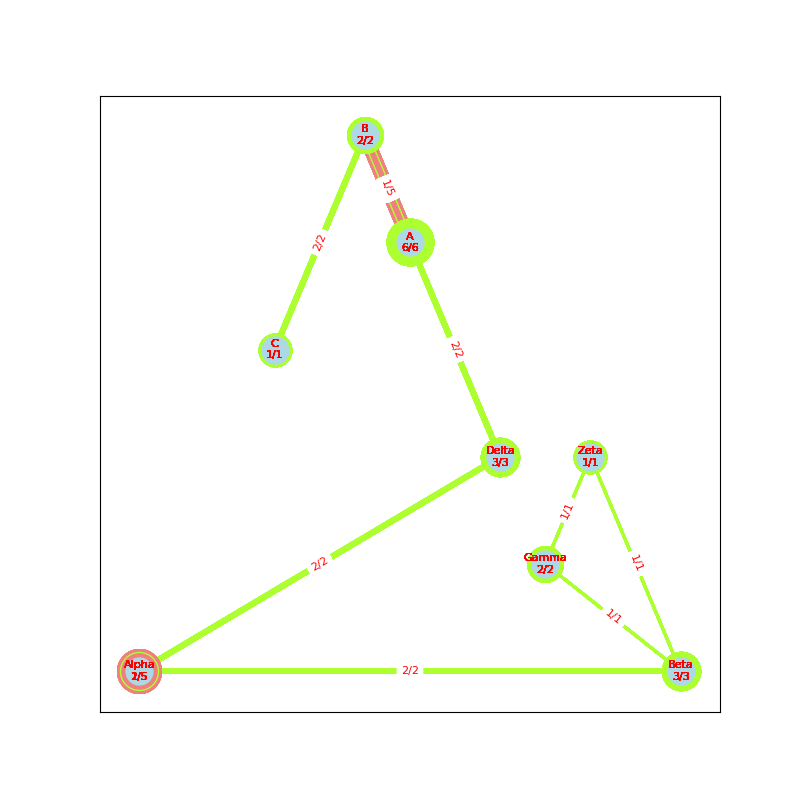

In [12]:
fig = plt.figure(figsize = (8 , 8))
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [13]:
for _ in range(20):
    time.sleep(0.1)
    r = random.randint(0,4)
    N.lock_station('Alpha')
    N.free_station('Alpha' , r)
    N.lock_track('A' , 'B')
    N.free_track('A' , 'B' , r)
    N.draw_railway_network(ax  = ax , suppress_station_info=False , suppress_track_info= False , suppress_edge_label=False)
    fig.canvas.draw()

In [14]:
N.trial()

**************************************************
Station 1
Station name : Alpha
Number of tracks : 5
Number of free tracks : 1
Track status
Track 0 : not free
Track 1 : not free
Track 2 : free
Track 3 : not free
Track 4 : not free
**************************************************
**************************************************
Station 2
Station name : Beta
Number of tracks : 3
Number of free tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
**************************************************
Station 3
Station name : Gamma
Number of tracks : 2
Number of free tracks : 2
Track status
Track 0 : free
Track 1 : free
**************************************************
**************************************************
Station 4
Station name : Delta
Number of tracks : 3
Number of free tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
******************